## Lấy giá trị dự báo thời tiết

In [2]:
import mysql.connector

mydb = mysql.connector.connect(
    host="sv-procon.uet.vnu.edu.vn",
    user="root",
    passwd="iotlab2018",
    database="irrigation_database"
)
print(mydb)
mycursor = mydb.cursor(buffered=True)

import datetime
datetime.time()
class status:
    def __init__(self,temperature,humidity):
        self.temperature=temperature
        self.humidity=humidity
    def __str__(self):
        return "temp: %f, hum: %f" % (self.temperature,self.humidity)
def formatTime(dt):
    return str(dt)
def nextHour(dt):
    return dt+datetime.timedelta(hours=1)
def getWeatherForecastAtATimeByTime(dt):
    mydb = mysql.connector.connect(
    host="sv-procon.uet.vnu.edu.vn",
    user="root",
    passwd="iotlab2018",
    database="irrigation_database")
    mycursor = mydb.cursor(buffered=True)
    print("querry %s"%str(dt))
    mycursor.execute("select WeatherForecastID from WeatherForecasts where CurrentTime = '%s'" %str(dt))
    wfid = mycursor.fetchone()
#     print(wfid)
    mycursor.execute("select Temperature, RelativeHumidity from WeatherForecastAtATimes where WeatherForecastID=%d" %wfid)
    ret = []
    result = mycursor.fetchall()
#     print(result)
    for i in range(len(result)):
        temp = status(result[i][0],result[i][1])
#         print(temp)
        ret.append(temp)
    return ret

## Khởi tạo 2 model cho việc nước tăng và nước giảm

### Mô hình độ ẩm đất tăng

In [3]:
class IncreaseModel:
    increaseDSoilMoisture = 1.2
    def getSoilMoisture(self,currentSM, periodTime):
        ret = currentSM+periodTime*self.increaseDSoilMoisture
        if ret >100:
            return 100
        return currentSM+periodTime*self.increaseDSoilMoisture
    def getPeriodTime(self,currentSM, destSM):
        if(destSM<currentSM):
            return -1
        return (destSM-currentSM)/self.increaseDSoilMoisture

### Mô hình độ ẩm đất giảm

In [4]:
from keras.models import load_model
import numpy as np
max_soilmoisture = 100
min_soilmoisture = 0
max_humidity = 100
min_humidity = 0
max_temperature = 50
min_temperature = 10
max_nextSoilMoisture = 100
min_nextSoilMoisture = 0

def scaleData(min_value, max_value, min_range, max_range, value):
    return min_range+((value-min_value)*(max_range-min_range))/(max_value-min_value)
def scaleDatas(min_value, max_value, min_range, max_range, values):
    values_ret=[]
    for i in range(len(values)):
        values_ret.append(scaleData(min_value, max_value, min_range, max_range, values[i]));
    return values_ret
decreaseModel = load_model("eva_hourly.h5")
def nextSoilMoistureAfterAnHour(currentSoilMoisture, wfat):
    scaleCurrentSoilMoisture=scaleData(min_soilmoisture,max_soilmoisture,0,1,currentSoilMoisture)
    scaleTemperature = scaleData(min_temperature,max_temperature,0,1,wfat.temperature)
    scaleHumidity = scaleData(min_humidity,max_humidity,0,1,wfat.humidity)
    nextSoilMoisture = decreaseModel.predict(np.array([[scaleCurrentSoilMoisture, scaleHumidity, scaleTemperature]]))
    ret = scaleData(0,1,min_soilmoisture,max_soilmoisture,nextSoilMoisture)
    return ret

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




## Giải thuật tưới MPC

In [5]:
wateringTimeLevel = [0,1,2,3]
increaseModel = IncreaseModel()
lostWaterTime = 0
minLostWaterTime = 9999999
solution = [0,0,0,0,0,0,0,0,0,0,0,0]
minSolution = [0,0,0,0,0,0,0,0,0,0,0,0]
upperThreshold = 80
lowerThreshold = 60
def init():
    global lostWaterTime
    global minLostWaterTime
    global solution
    global minSolution
    global upperThreshold
    global lowerThreshold
    lostWaterTime = 0
    minLostWaterTime = 9999999
    solution = [0,0,0,0,0,0,0,0,0,0,0,0]
    minSolution = [0,0,0,0,0,0,0,0,0,0,0,0]
    upperThreshold = 80
    lowerThreshold = 60
def watering(soilMoisture, lostWaterTime, periodTime):
#     print("before: %f" %currentSoilMoisture)
    temp = increaseModel.getSoilMoisture(soilMoisture,periodTime)
    soilMoisture=temp
#     print("after: %f" %currentSoilMoisture)
    lostWaterTime+=periodTime
    return soilMoisture, lostWaterTime
def resetWatering(resetSoilMoisture, lostWaterTime, periodTime):
    soilMoisture = resetSoilMoisture
    lostWaterTime-=periodTime
    return soilMoisture, lostWaterTime
def isSatisfyCondition(soilMoisture, minLostWaterTime):
    global lowerThreshold, upperThreshold
    if lostWaterTime>minLostWaterTime:
#         print("bad")
        return False
    if soilMoisture>upperThreshold or soilMoisture<lowerThreshold:
#         print("outside")
        return False
    return True

# tim lượng nước tưới trong 12 h tới tối ưu và k vi phạm ràng buộc
def calWatering(soilMoisture):
    global lostWater,lostWaterTime,minSolution,solution,wateringLevel, minLostWaterTime, minLostWater
    if index == 12:
        
        if lostWaterTime < minLostWaterTime:
            minLostWaterTime = lostWaterTime
            minSolution = solution.copy()
            print("solution: ")
            print(minSolution)
    else:
        for t in wateringTimeLevel:
#             print("index: %d, w: %d"% (index,w))
            resetSoilMoisture = soilMoisture
#             print("before: %f" %soilMoisture)
            soilMoisture = watering(soilMoisture, t)
            solution[index] = t
            
            soilMoisture=nextSoilMoistureAfterAnHour(soilMoisture,wfats[index])
#             print("after: %f " %soilMoisture)
            if(not isSatisfyCondition(soilMoisture)):
                soilMoisture = resetWatering(t,resetSoilMoisture)
                continue
            calWatering(soilMoisture, index+1)
            soilMoisture = resetWatering(t,resetSoilMoisture)
    
def selectWatering(soilMoisture, startTime):
#     print("select Watering - soilMoisture: %f"%soilMoisture)
    wfats = getWeatherForecastAtATimeByTime(startTime)
    calWatering(soilMoisture)
    print(minSolution)
    return minSolution[0]


In [9]:
startTime = datetime.datetime(2020,5,3,6,0,0)
soilMoisture = 63
soilMoisturesAndTimes = []

increaseModel = IncreaseModel()

for i in range(48):
    soilMoisture=float(soilMoisture)
    soilMoisturesAndTimes.append([soilMoisture,startTime,0])
    if soilMoisture<lowerThreshold:
        t=increaseModel.getPeriodTime(currentSM=soilMoisture,destSM=upperThreshold)
#         print(t)
        t=float(t)
#         print(t)
        nextTime=startTime+datetime.timedelta(seconds=t)
        soilMoisturesAndTimes.append([upperThreshold,nextTime,t])
        soilMoisture=upperThreshold
    wfats = getWeatherForecastAtATimeByTime(startTime)
    soilMoisture=nextSoilMoistureAfterAnHour(currentSoilMoisture=soilMoisture,wfat=wfats[0])
    startTime=nextHour(startTime)
print(soilMoisturesAndTimes)

querry 2020-05-03 06:00:00
querry 2020-05-03 07:00:00
querry 2020-05-03 08:00:00
querry 2020-05-03 09:00:00
querry 2020-05-03 10:00:00
querry 2020-05-03 11:00:00
querry 2020-05-03 12:00:00
querry 2020-05-03 13:00:00
querry 2020-05-03 14:00:00
querry 2020-05-03 15:00:00
querry 2020-05-03 16:00:00
querry 2020-05-03 17:00:00
querry 2020-05-03 18:00:00
querry 2020-05-03 19:00:00
querry 2020-05-03 20:00:00
querry 2020-05-03 21:00:00
querry 2020-05-03 22:00:00
querry 2020-05-03 23:00:00
querry 2020-05-04 00:00:00
querry 2020-05-04 01:00:00
querry 2020-05-04 02:00:00
querry 2020-05-04 03:00:00
querry 2020-05-04 04:00:00
querry 2020-05-04 05:00:00
querry 2020-05-04 06:00:00
querry 2020-05-04 07:00:00
querry 2020-05-04 08:00:00
querry 2020-05-04 09:00:00
querry 2020-05-04 10:00:00
querry 2020-05-04 11:00:00
querry 2020-05-04 12:00:00
querry 2020-05-04 13:00:00
querry 2020-05-04 14:00:00
querry 2020-05-04 15:00:00
querry 2020-05-04 16:00:00
querry 2020-05-04 17:00:00
querry 2020-05-04 18:00:00
q

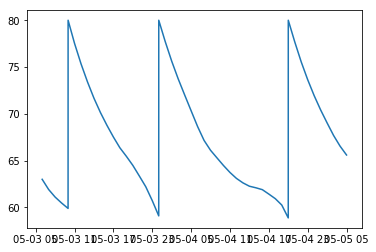

In [10]:
import matplotlib.pyplot as plt
temp = np.array(soilMoisturesAndTimes).transpose()
plt.plot(temp[1],temp[0])

In [11]:
sumTime=[]
sumTime.append(temp[2][0])
for i in range(1,len(temp[2])):
    sumTime.append(sumTime[i-1]+temp[2][i])
print(sumTime)
# print((temp[0]))

[0, 0, 0, 0, 0, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 16.759487787882488, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 34.183295567830406, 51.789070765177414, 51.789070765177414, 51.789070765177414, 51.789070765177414, 51.789070765177414, 51.789070765177414, 51.789070765177414, 51.789070765177414, 51.789070765177414, 51.789070765177414]


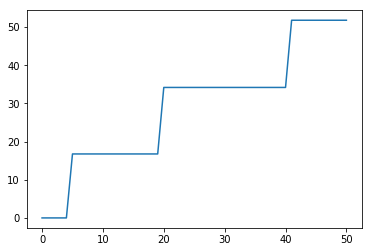

In [12]:
plt.plot(sumTime)

In [13]:
import pandas as pd
soilMoistureFolowTimeByONOFF = pd.DataFrame(temp.transpose(),columns=['soil moisture','datetime','amount of watering'])
soilMoistureFolowTimeByONOFF.to_csv("soil_moisture_on_off.csv")